Мы запустили сплит-тест платежной формы, чтобы проверить следующую гипотезу:
● Если убрать поле для ввода Name on card, то вырастет конверсия в нажатие
кнопки Pay, т.к. пользователям придётся вводит меньше данных.

# Цель
Нужно подсчитать результаты сплит-теста, проанализировать и написать выводы по ним
(какая форма выиграла, на какой из платформ был получен более значимый результат,
что могло повлиять на результат сплит-теста и над чем следует поработать для
оптимизации конверсии).

Он содержит:
    ● Уникальный идентификатор посещения - idvisit
    ● Conversion, где 1 - результат успешного нажатия кнопки Pay
    ● Поле A/B, где old - старая форма, new - новая форма без Name on card
    ● Прочие атрибуты
    
Решение должно состоят из 2-х частей: расчеты (Python, iPython Notebook, Excel) и файл с выводами и графиками.

In [32]:
# установка необх.библиотек
# import sys
!pip3 install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

!pip3 install pandas
!pip3 install xlrd
!pip3 install scipy
!pip3 install statsmodels
!pip3 install matplotlib
!pip3 install seaborn

Requirement already up-to-date: google-api-python-client in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (1.12.3)
Requirement already up-to-date: google-auth-httplib2 in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (0.0.4)
Requirement already up-to-date: google-auth-oauthlib in /Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages (0.4.1)
     |████████████████████████████████| 103 kB 581 kB/s eta 0:00:01


In [294]:
# импорты 
import io
from googleapiclient.http import MediaIoBaseDownload
import googleapiclient.discovery
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools

import pandas as pd

In [295]:
# проводим аутентификацию через гугловую апишку

obj = lambda: None
lmao = {"auth_host_name":'localhost', 'noauth_local_webserver':'store_true', 'auth_host_port':[8080, 8090], 'logging_level':'ERROR'}
for k, v in lmao.items():
    setattr(obj, k, v)
    
# authorization boilerplate code
SCOPES = 'https://www.googleapis.com/auth/drive.readonly'
store = file.Storage('token.json')
creds = store.get()
# The following will give you a link if token.json does not exist, the link allows the user to give this app permission
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('credentials.json', SCOPES)
    creds = tools.run_flow(flow, store, obj)

/Users/nsh/.pyenv/versions/3.7.2/lib/python3.7/site-packages/oauth2client/_helpers.py:255: UserWarning: Cannot access token.json: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))


InvalidClientSecretsError: ('Error opening file', 'credentials.json', 'No such file or directory', 2)

In [28]:
# считываем необходимый файл. Удобно забирать прямо с диска - все изменения на диске тянем сразу 
#  (перезаписываем файл на локальной машине)

DRIVE = googleapiclient.discovery.build(serviceName='drive'
                                        , version='v3'
                                        , http=creds.authorize(Http()))
# if you get the shareable link, the link contains this id, replace the file_id below

file_id = '16-kZKQIdjeKErkEyPilollVPCj2CHzy1'
request = DRIVE.files().get_media(fileId=file_id)
# replace the filename and extension in the first field below
fh = io.FileIO('solid_split.xlsx', mode='w')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100)) 

Download 100%.


# Formulating a hypothesis

# Choosing a sample size

First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.
Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a two-tailed test:
Hₒ: p = pₒ
Hₐ: p ≠ pₒ
where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:
α = 0.05
The α value is a threshold we set, by which we say “if the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the Null hypothesis”. Since our α=0.05 (indicating 5% probability), our confidence (1 — α) is 95%.

how many people should we have in each group?

The sample size we need is estimated through something called Power analysis, and it depends on a few factors:
    # Power of the test (1 — β) — This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 by convention (here’s more info on statistical power, if you are curious)
    # Alpha value (α) — The critical value we set earlier to 0.05
    # Effect size — How big of a difference we expect there to be between the conversion rates

In [105]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(f'We’d need at least {required_n} observations for each group')

We’d need at least 4720 observations for each group


Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [29]:
# путь к исходному файлу с результатами теста
path_to_file = './solid_split.xlsx'

In [82]:
# чтение файла в датафрейм
split = pd.read_excel(path_to_file).fillna('-99')

split.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
10230,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,7,360x640,5830984,MOB
479,SAMSUNG,CHROME MOBILE,SMARTPHONE,1,old,AND,6,360x640,4128527,MOB
719,Other,CHROME,DESKTOP,1,old,WIN,10,1366x768,4428088,WEB


1) нету даты (timestamp), за какой период результаты. Для меня важно понимание длительность.
2) Отсутствует user_id - хотелось бы проверить по юзеру или по куки файлу не было ли повторных транзакций у форме. + не было ли в юзера пересечений?

In [284]:
# No action required: Leave the original dataframe untouched and sort the new dataframe
split2 = split.copy()

In [285]:
split2.sample(6)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
186,Other,FIREFOX,DESKTOP,1,old,WIN,7,1366x768,3903731,WEB
12185,HUAWEI,CHROME MOBILE,SMARTPHONE,0,new,AND,5.1,360x640,5025236,MOB
18289,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,7,360x640,4982749,MOB
22189,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,5.1,360x640,3863865,MOB
9493,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,5.1,360x640,4694762,MOB
6415,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,5.1,320x570,4264237,MOB


In [286]:
# из-за отсутствия id_user сделаю проверку по идентификатору визита
session_counts = split2['idvisit'].value_counts(ascending=False)
multi_visit = session_counts[session_counts > 1].count()

print(f'There are {multi_visit} users that appear multiple times in the dataset')

# окей с отсутствием дублей

There are 0 users that appear multiple times in the dataset


In [287]:
# список измерений для группировки и вычислений
diminsion_col = ['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_os_version', 'config_resolution', 'platform_v4']

In [288]:
# считаем кол-во визитов в разрезе необходимых измерений
split2['visit_cnt'] = split2.groupby(diminsion_col)['idvisit'].transform('count')


split2 = split2.astype({"visit_cnt": int}, errors='ignore')

split2 = split2.filter(['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_resolution', 'config_os_version', 'platform_v4', 'visit_cnt'])

split2.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_resolution,config_os_version,platform_v4,visit_cnt
14518,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,360x640,5.1,MOB,413
9864,Other,FIREFOX,DESKTOP,0,old,WIN,1366x768,7,WEB,47
25027,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,360x640,6,MOB,1200


In [289]:
# что там по конверсии в разных группах?
pd.crosstab(split2['A/B'], split2['Conversion']
            , margins=True, margins_name="Total")

Conversion,0,1,Total
A/B,,,
new,13564,1865,15429
old,9806,1350,11156
Total,23370,3215,26585


Присущий неравномерно распределенный трафик в тестовой и контрольной группе. Почему 

In [290]:
pd.crosstab(split2['A/B']
            ,split2['Conversion'], normalize='index')

Conversion,0,1
A/B,,
new,0.879124,0.120876
old,0.878989,0.121011


## Sampling

In [131]:
# random_state=22 для воспроизводимости результатов
control_sample = split2[split2['A/B'] == 'old'].sample(n=required_n, random_state=22)
test_sample = split2[split2['A/B'] == 'new'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, test_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
826,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,7,360x640,3948689,MOB
4675,Other,CHROME,DESKTOP,0,old,WIN,8.1,1366x768,3886627,WEB
8054,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,6,360x640,6097537,MOB


In [132]:
# List of names of unique names of the segments
brows_list = list(split2['BROWSERS'].unique())
dev_br_list = list(split2['DEVICES_BRANDS'].unique())
dev_type_list = list(split2['DEVICE_TYPE'].unique())
platf_list = list(split2['platform_v4'].unique())

In [133]:
# Count of the number of segments (or total test variations)
variations_brows = len(brows_list)
variations_dev_brand = len(dev_br_list)
variations_dev_type = len(dev_type_list)
variations_platf = len(platf_list)

# Verify that the segments/categories are correct 
print('Different brow: ',brows_list, 'Number of segments: ', variations_brows)
print('Different dev brand: ',dev_br_list, 'Number of segments: ', variations_dev_brand)
print('Different device type: ',dev_type_list, 'Number of segments: ', variations_dev_type)
print('Different version platform: ',platf_list, 'Number of segments: ', variations_platf)

Different brow:  ['CHROME MOBILE', 'Other', 'MOBILE SAFARI', 'CHROME', 'FIREFOX'] Number of segments:  5
Different dev brand:  ['Other', 'SAMSUNG', 'APPLE', 'HUAWEI'] Number of segments:  4
Different device type:  ['SMARTPHONE', '-99', 'PHABLET', 'DESKTOP', 'TABLET', 'PORTABLE_MEDIA_PAYER'] Number of segments:  6
Different version platform:  ['MOB', 'WEB'] Number of segments:  2


## Visualising the results

In [291]:
conversion_rates = ab_test.groupby(['A/B'])['Conversion']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
A/B,,,
new,0.125,0.331,0.005
old,0.126,0.331,0.005


Text(0, 0.5, 'Converted (proportion)')

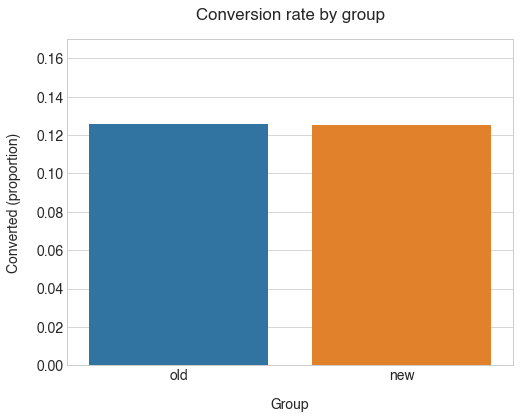

In [292]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['A/B'], y=ab_test['Conversion'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

# https://habr.com/ru/company/changeagain/blog/294238/

# Конверсия по типу платформы (Conversions Per Platform)

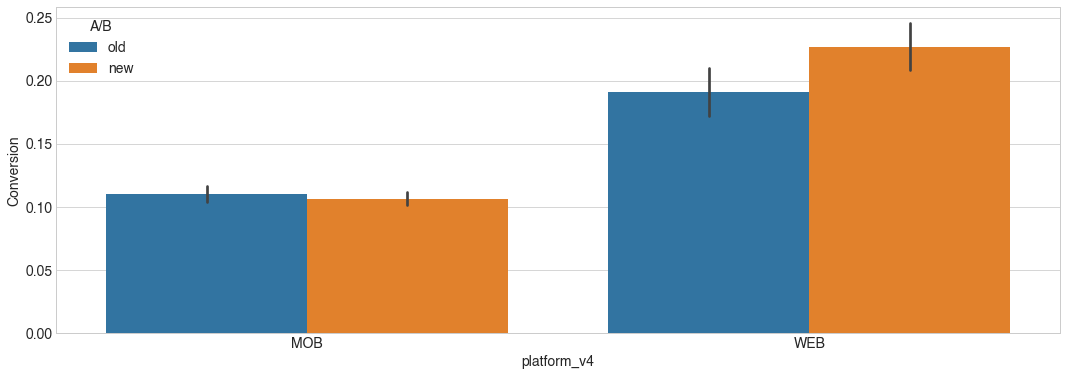

In [236]:
# platform_v4

fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='platform_v4'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

По новой форме конверсия на вебе больше, чем на мобиле. Почему?

In [ ]:
Если печаль, то смотрим на структуру трафика

# Конверсия по типу платформы (Conversions Per Platform)

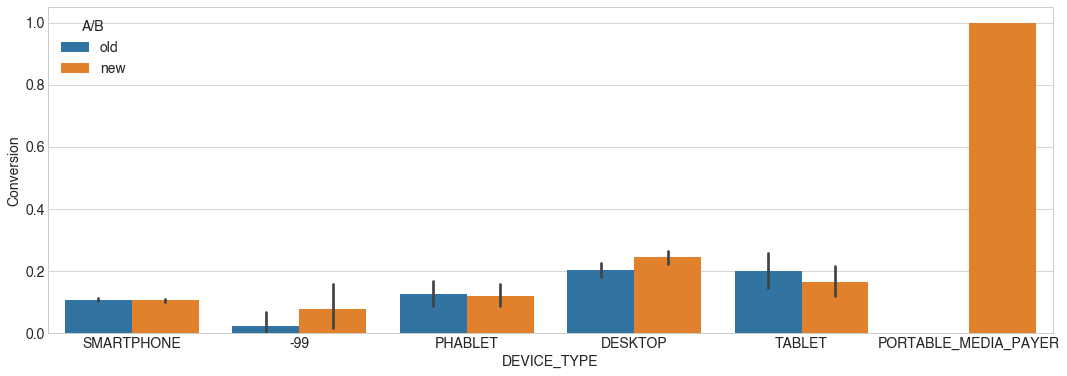

In [237]:
# DEVICE_TYPE в целом
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

идет просадка на смартфонах и фаблетах (гибрид телефона+планшета), важно понять какую долю они занитмают в структуре трафика? поскольку практически 90%, то необходимо понять, что внутри не так...

<AxesSubplot:ylabel='visit_cnt'>

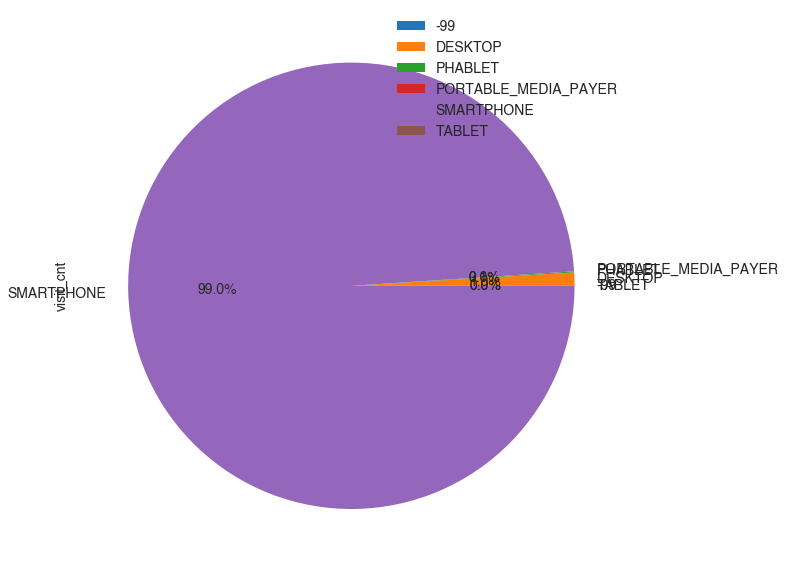

In [247]:
split2.groupby(['DEVICE_TYPE']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(10,15)
                                             , autopct='%1.1f%%')

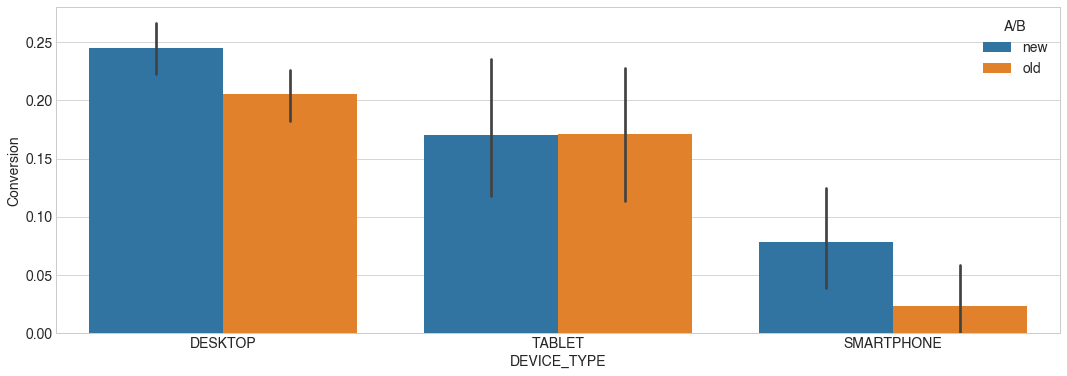

In [248]:
# DEVICE_TYPE на вебе 
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='WEB'], ax=ax)
plt.show()

### На всех типах веба идет рост.

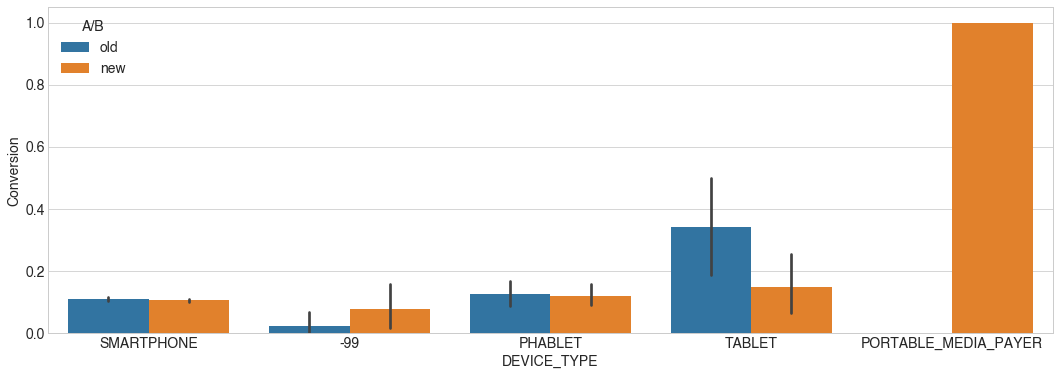

In [249]:
# DEVICE_TYPE на вебе
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='MOB'], ax=ax)
plt.show()

### На всех типах падение, но не было новой версии на таблете.

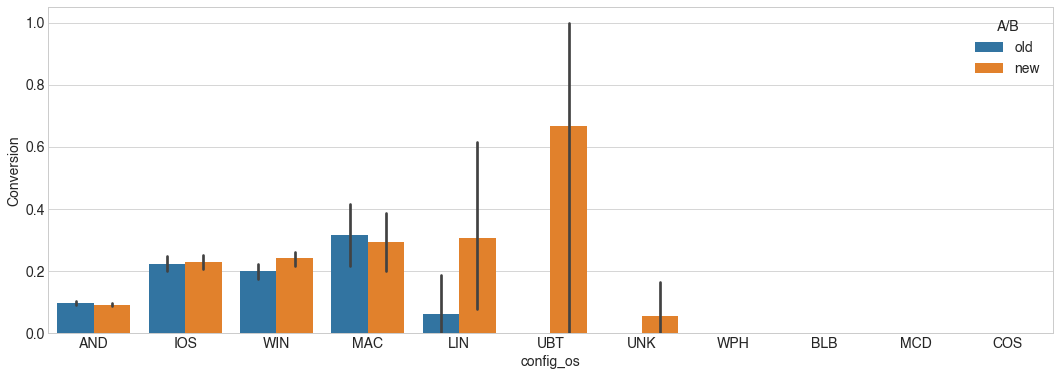

In [254]:
# config_os
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='config_os'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

<AxesSubplot:ylabel='visit_cnt'>

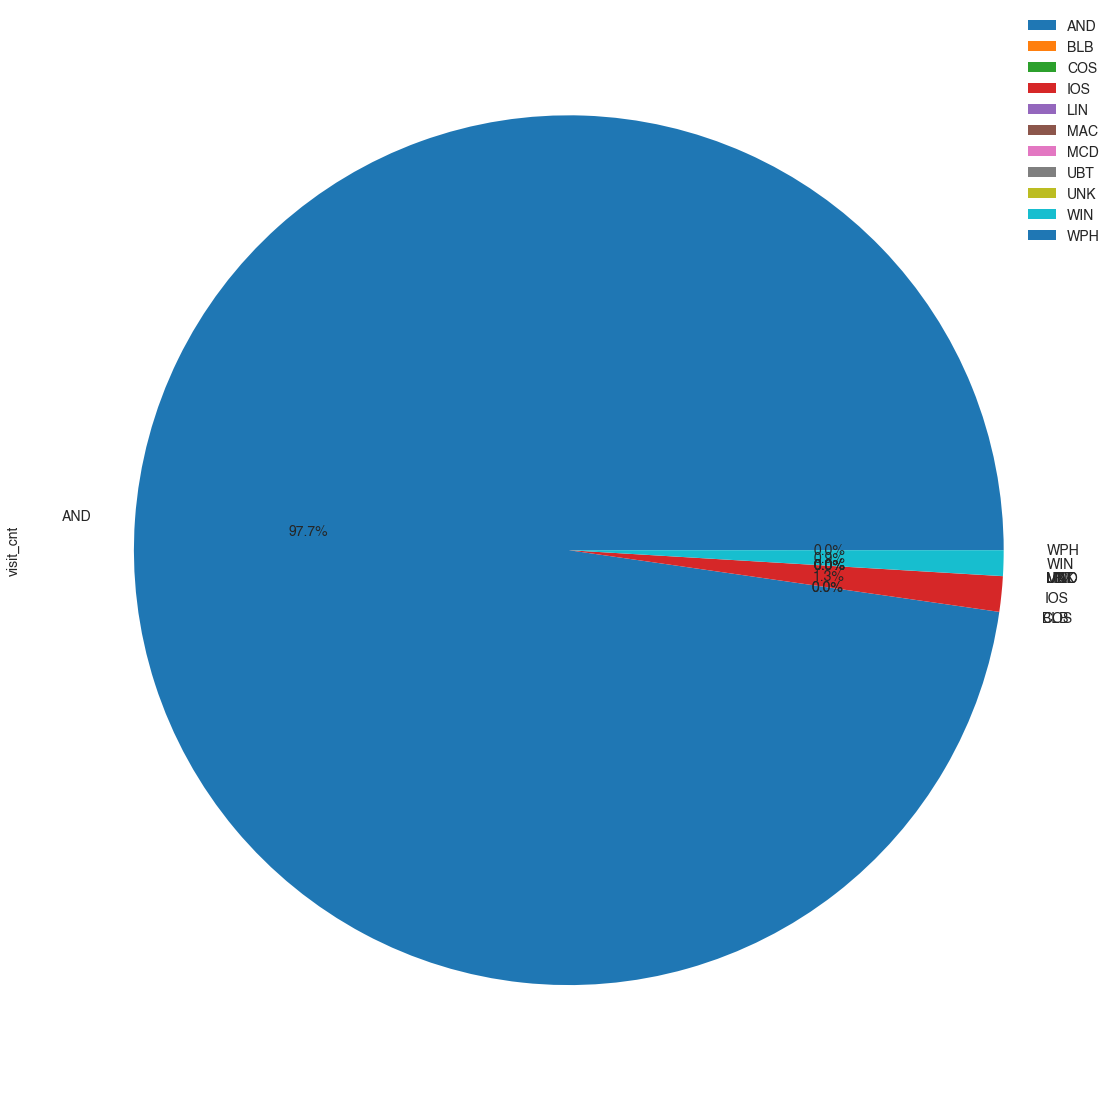

In [253]:
split2.groupby(['config_os']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,20)
                                             , autopct='%1.1f%%')

понижение на андроиде - плохо, т.к. это практически весь трафик

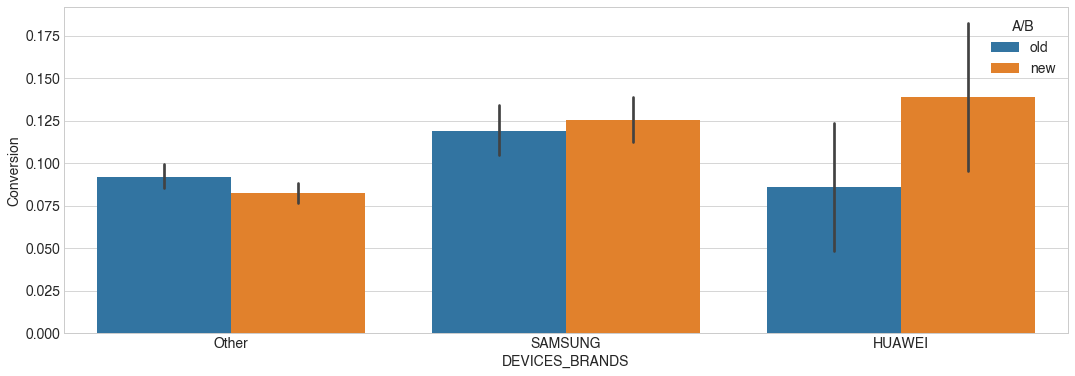

In [256]:
# DEVICES_BRANDS
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICES_BRANDS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.config_os=='AND'], ax=ax)
plt.show()

<AxesSubplot:ylabel='visit_cnt'>

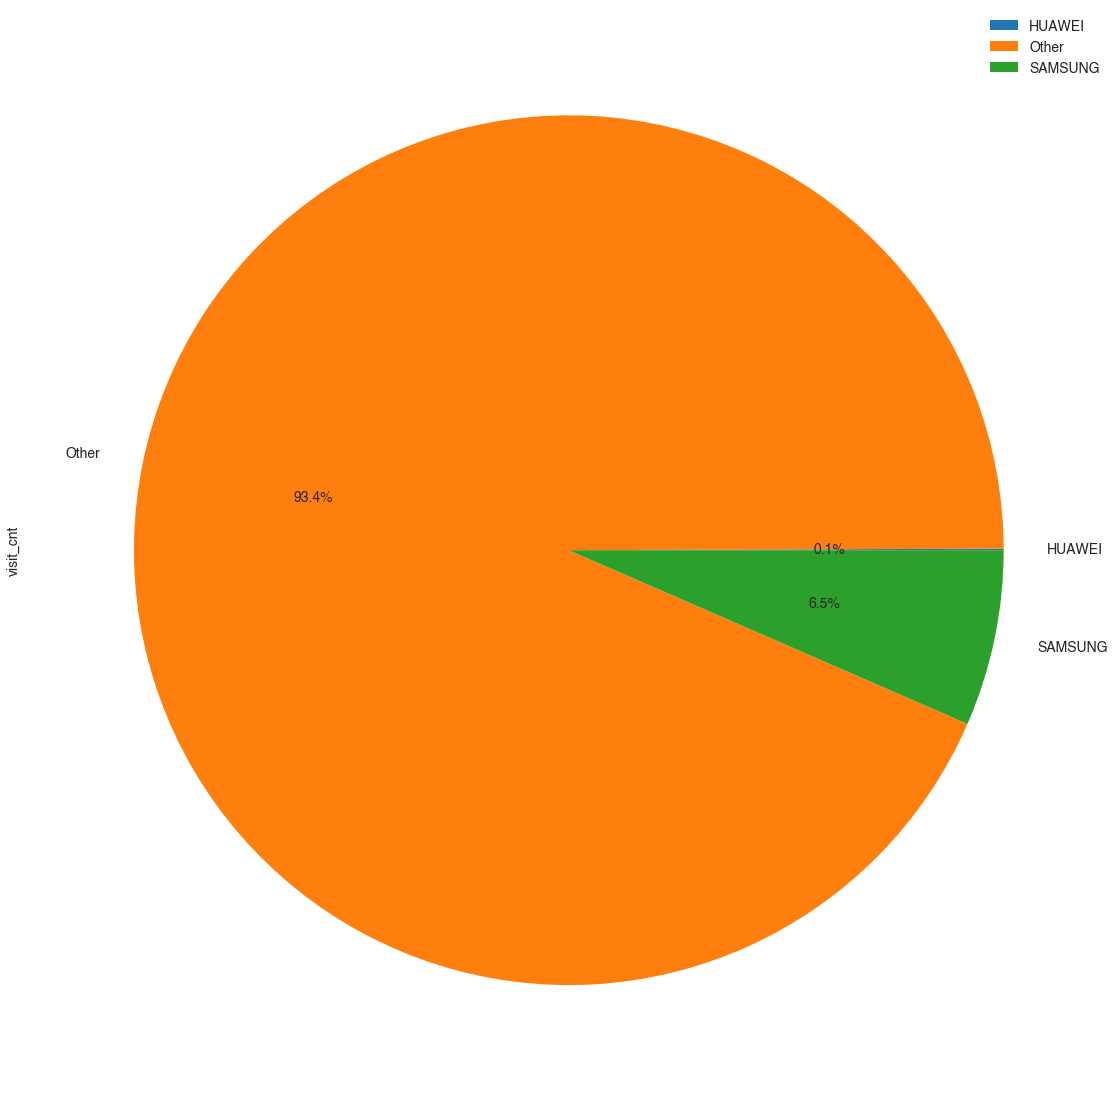

In [257]:
split2[split2.config_os=='AND'].groupby(['DEVICES_BRANDS']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,20)
                                             , autopct='%1.1f%%')

покопать что туть? 
split2.config_os=='AND')
                          &(split2.DEVICES_BRANDS=='Other')

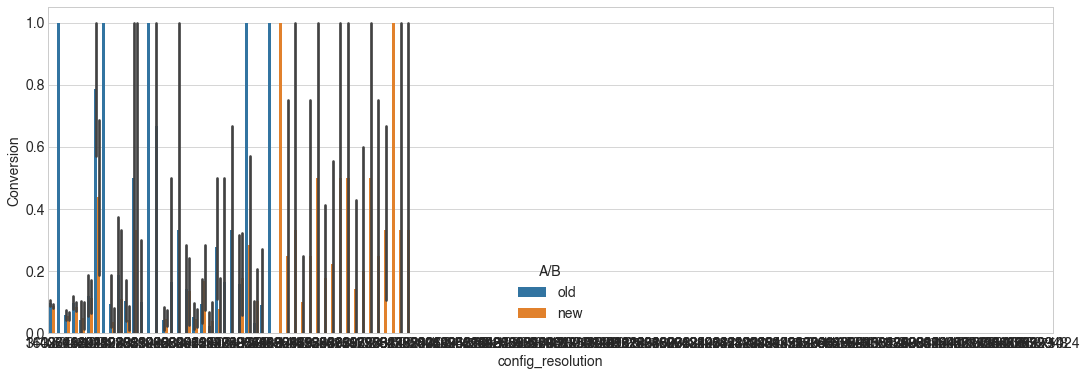

In [258]:
# config_os
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='config_resolution'
            , y='Conversion'
            , hue='A/B'
            , data=split2[(split2.config_os=='AND')
                          &(split2.DEVICES_BRANDS=='Other')], ax=ax)
plt.show()

# Конверсия по браузерам (Conversions Per Browser)

<AxesSubplot:ylabel='visit_cnt'>

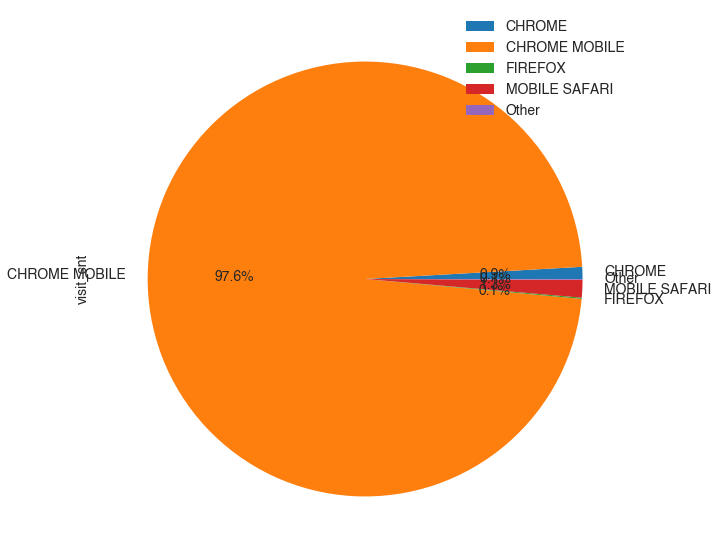

In [270]:
split2.groupby(['BROWSERS']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,10)
                                             , autopct='%1.1f%%')

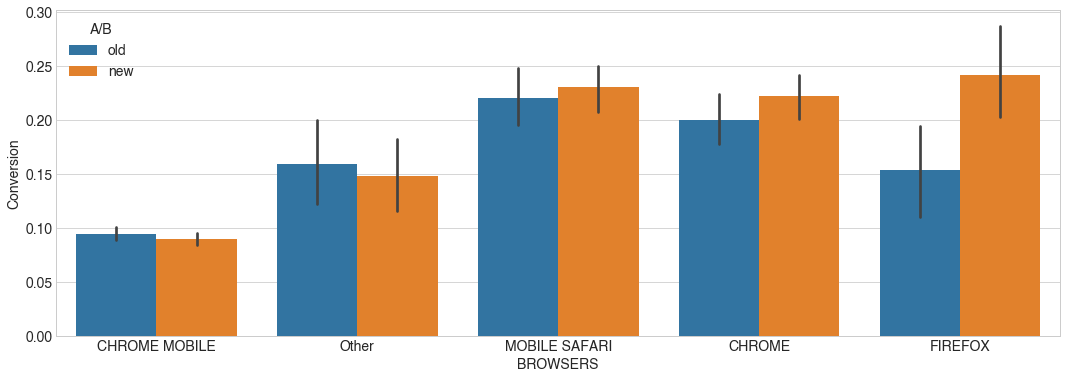

In [259]:
# BROWSERS
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

Потестить, что не так с Chrome mobile и Другие в тестовой группе. Возможно что-то с отобрабражением формы. Т.к. на других - ок.

!!! взять разрешение экрана..

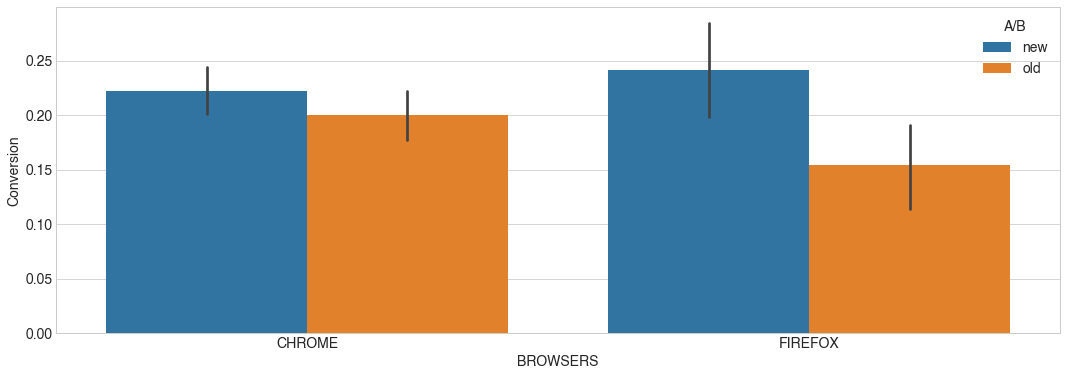

In [261]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='WEB'], ax=ax)
plt.show()

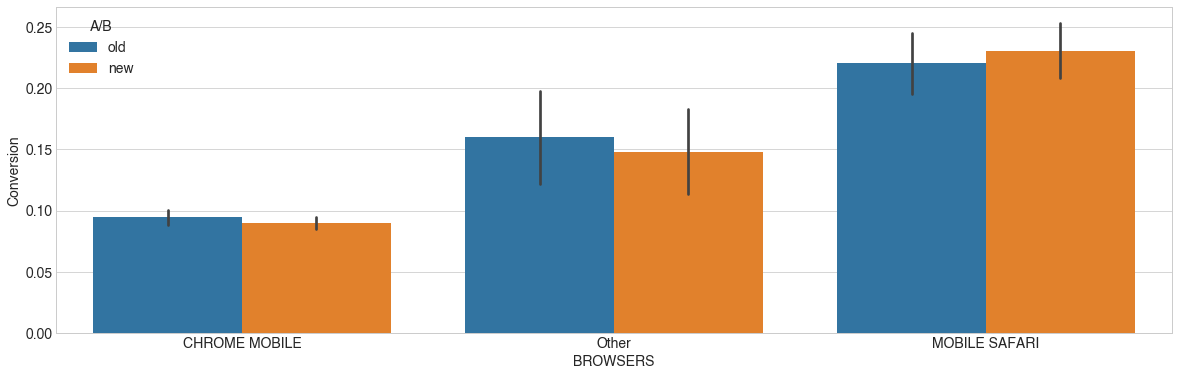

In [274]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='MOB'], ax=ax)
plt.show()

In [280]:
# config_os

ch_mob = split2[split2.BROWSERS=='CHROME MOBILE']


ch_mob

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_resolution,platform_v4,visit_cnt
0,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,360x640,MOB,378
2,SAMSUNG,CHROME MOBILE,SMARTPHONE,1,new,AND,360x640,MOB,140
4,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,360x640,MOB,378
5,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,360x640,MOB,378
6,Other,CHROME MOBILE,SMARTPHONE,1,old,AND,360x640,MOB,378
...,...,...,...,...,...,...,...,...,...
26578,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,360x640,MOB,4751
26579,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,360x720,MOB,1448
26582,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,360x640,MOB,4751
26583,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,360x640,MOB,4751


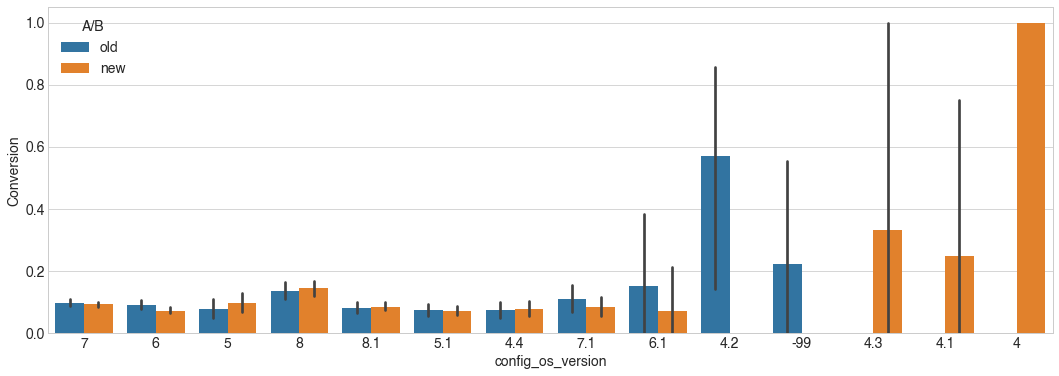

In [293]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='config_os_version'
            , y='Conversion'
            , hue='A/B'
            , data=split2 [split2.BROWSERS=='CHROME MOBILE']
            #, data=split2[split2.BROWSERS=='CHROME MOBILE']
            , ax=ax)
plt.show()

# Конверсия по девайсам 

# Testing the hypothesis

In [122]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint


control_results = ab_test[ab_test['A/B'] == 'old']['Conversion']
test_results = ab_test[ab_test['A/B'] == 'new']['Conversion']

n_con = control_results.count()
n_test = test_results.count()
successes = [control_results.sum(), test_results.sum()]
nobs = [n_con, n_test]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_test), (upper_con, upper_test) = proportion_confint(successes
                                                                      , nobs=nobs
                                                                      , alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_test:.3f}, {upper_test:.3f}]')

z statistic: 0.09
p-value: 0.926
ci 95% for control group: [0.116, 0.135]
ci 95% for treatment group: [0.116, 0.134]


# Drawing conclusions

Since our p-value=0.926 is way above our α=0.05 threshold, we cannot reject the Null hypothesis Hₒ, which means that our new design did not perform significantly different (let alone better) than our old one :(
Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], or 11.6-13.5%) we notice that:
It includes our baseline value of 13% conversion rate
It does not include our target value of 15% (the 2% uplift we were aiming for)
What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!

## Segment Summary

в разрезе формы A/B (old, new) - conv=1
в разрезе платформ
